# Important Traffic Nodes

### Initialize

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,TimestampType

spark = SparkSession \
    .builder \
    .appName("Spark_Processor") \
    .master("local[*]") \
    .getOrCreate()

sc = spark.sparkContext

schema = StructType([ \
        StructField("DEVICE_CODE", IntegerType(), True), 
        StructField("SYSTEM_ID",IntegerType(),True), \
        StructField("ORIGINE_CAR_KEY",IntegerType(),True), \
        StructField("FINAL_CAR_KEY", IntegerType(),True), \
        StructField("CHECK_STATUS_KEY", IntegerType(), True), \
        StructField("COMPANY_ID", StringType(), True), \
        StructField("PASS_DAY_TIME", TimestampType(), True)
    ])

22/02/10 12:32:53 WARN Utils: Your hostname, jupyter resolves to a loopback address: 127.0.1.1; using 172.16.199.67 instead (on interface eth0)
22/02/10 12:32:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/10 12:32:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read.csv('Traffic.csv',header=True,schema=schema)
df.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|     200501|       81|       10477885|     10477885|               5|       161|2021-06-01 03:54:39|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 1 row



### Keep only 7 days

In [13]:
from pyspark.sql.functions import dayofyear
df = df.withColumn('day', dayofyear(df.PASS_DAY_TIME))
df = df.filter(df.day != 159)
df.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|day|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
|     200501|       81|       10477885|     10477885|               5|       161|2021-06-01 03:54:39|152|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
only showing top 1 row



### Remove outliers

In [14]:
from pyspark.sql.functions import count
from pyspark.sql.window import Window

window = Window.partitionBy('FINAL_CAR_KEY')
df_with_car_count = df.withColumn('count', count('FINAL_CAR_KEY').over(window))
df_cleaned = df_with_car_count.filter(df_with_car_count['count'] < 1000)
df_cleaned.show(5)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+-----+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|day|count|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+-----+
|        114|       81|        7631984|      7631984|               5|       161|2021-06-03 07:34:29|154|   15|
|     631781|       81|        7631984|      7631984|               5|       161|2021-06-03 07:32:39|154|   15|
|     900130|      283|        7631984|      7631984|               5|       264|2021-06-03 13:04:24|154|   15|
|     203001|       81|        7631984|      7631984|               5|       161|2021-06-03 13:13:56|154|   15|
|     631349|       81|        7631984|      7631984|               5|       161|2021-06-03 13:26:40|154|   15|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---

In [15]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import IntegerType

df_cleaned_indexed = StringIndexer(inputCol='DEVICE_CODE', outputCol='camera').fit(df_cleaned).transform(df_cleaned)
df_cleaned_indexed = df_cleaned_indexed.withColumn('camera', df_cleaned_indexed['camera'].cast(IntegerType()))
df_cleaned_indexed.show(5)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+-----+------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|day|count|camera|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+-----+------+
|        114|       81|        7631984|      7631984|               5|       161|2021-06-03 07:34:29|154|   15|    43|
|     631781|       81|        7631984|      7631984|               5|       161|2021-06-03 07:32:39|154|   15|   342|
|     900130|      283|        7631984|      7631984|               5|       264|2021-06-03 13:04:24|154|   15|   297|
|     203001|       81|        7631984|      7631984|               5|       161|2021-06-03 13:13:56|154|   15|   279|
|     631349|       81|        7631984|      7631984|               5|       161|2021-06-03 13:26:40|154|   15|   356|
+-----------+---------+---------------+---------

In [16]:
# df_cleaned_indexed.groupBy('camera').count().sort('count', ascending=False).show()
# df_cleaned_indexed.groupBy('FINAL_CAR_KEY').count().sort('count', ascending=False).show()

In [17]:
from pyspark.sql.functions import dayofyear, lead

df_with_day = df_cleaned_indexed.withColumn('day', dayofyear(df.PASS_DAY_TIME))

window = Window.partitionBy('FINAL_CAR_KEY', 'day').orderBy('FINAL_CAR_KEY','PASS_DAY_TIME')
df_with_next = df_with_day.withColumn('next', lead('camera', offset=1,  default=-1).over(window))
df_with_next = df_with_next.filter(df_with_next.next != -1).select('FINAL_CAR_KEY', 'day', 'camera', 'next')
df_with_next.show(5)

+-------------+---+------+----+
|FINAL_CAR_KEY|day|camera|next|
+-------------+---+------+----+
|      7631984|154|   342|  43|
|      7631984|154|    43| 297|
|      7631984|154|   297| 228|
|      7631984|154|   228| 279|
|      7631984|154|   279| 312|
+-------------+---+------+----+
only showing top 5 rows



In [18]:
graph_df = df_with_next.groupBy(
    'camera',
    'next'
).count()
graph_df.show(5)

+------+----+-----+
|camera|next|count|
+------+----+-----+
|   115| 401|  304|
|    32|  26|16503|
|   114| 194|  488|
|   114|  15| 1129|
|   241| 131|   42|
+------+----+-----+
only showing top 5 rows



In [19]:
from pyspark.mllib.linalg.distributed import CoordinateMatrix
utility_matrix = CoordinateMatrix(graph_df.rdd.map(lambda x: (int(x['camera']), int(x['next']), x['count']) ))
print(utility_matrix.numCols())
print(utility_matrix.numRows())

1022
1024


In [3]:
simpleData = (("James", "Sales", 3000), \
    ("Michael", "Sales", 4600),  \
    ("Robert", "Sales", 4100),   \
    ("Maria", "Finance", 3000),  \
    ("James", "Sales", 3000),    \
    ("Scott", "Finance", 3300),  \
    ("Jen", "Finance", 3900),    \
    ("Jeff", "Marketing", 3000), \
    ("Kumar", "Marketing", 2000),\
    ("Saif", "Sales", 4100) \
  )
 
columns= ["employee_name", "department", "salary"]
grpah_df = spark.createDataFrame(data = simpleData, schema = columns)
grpah_df.printSchema()
grpah_df.show(truncate=False)

root
 |-- employee_name: string (nullable = true)
 |-- department: string (nullable = true)
 |-- salary: long (nullable = true)



+-------------+----------+------+
|employee_name|department|salary|
+-------------+----------+------+
|James        |Sales     |3000  |
|Michael      |Sales     |4600  |
|Robert       |Sales     |4100  |
|Maria        |Finance   |3000  |
|James        |Sales     |3000  |
|Scott        |Finance   |3300  |
|Jen          |Finance   |3900  |
|Jeff         |Marketing |3000  |
|Kumar        |Marketing |2000  |
|Saif         |Sales     |4100  |
+-------------+----------+------+



In [30]:
from pyspark.mllib.linalg.distributed import CoordinateMatrix
utility_matrix2 = CoordinateMatrix(grpah_df.rdd.map(lambda x: (22,11,1)))
print(utility_matrix2.numRows())
print(utility_matrix2.numCols())
# svd2 = utility_matrix2.toRowMatrix().computeSVD(10, computeU=True)
# hubs2 = svd2.U.rows.map(lambda x: x.toArray()[0] * -1).collect()
# auths2 = svd2.V.toArray()
# auths2 = auths2[:,0] * -1
# # print(auths)
# print('number of hubs: ', len(hubs2))
# print('number of auth: ', len(auths2))

23
12


In [44]:
svd = utility_matrix.toRowMatrix().computeSVD(10, computeU=True)
u = svd.U
s = svd.s
v = svd.V
print(u)
print(s)
print(v)

22/02/10 12:54:56 WARN RowMatrix: The input data is not directly cached, which may hurt performance if its parent RDDs are also uncached.


[386741.66052041174,214540.89004039083,134342.6053269712,119643.50388471477,105990.32825396415,95462.4460834679,88385.36613613699,83931.94580445538,78952.91922846096,76106.5565333638]
DenseMatrix([[ 2.80028746e-02, -9.10351853e-01, -1.51801914e-02, ...,
              -1.40691615e-02,  8.60266938e-03,  4.58349304e-02],
             [ 9.91106269e-01,  3.67875503e-02, -1.93493747e-03, ...,
              -2.43548991e-02, -5.32753265e-03, -2.60319828e-03],
             [ 8.44525330e-03, -2.74138588e-01,  1.26195916e-02, ...,
              -2.06705102e-01,  2.02635485e-02,  9.44339304e-02],
             ...,
             [ 1.51307902e-09, -3.19552388e-08,  3.30655677e-08, ...,
              -3.64411014e-07, -9.57783433e-07, -1.61163627e-06],
             [ 2.86527960e-10, -2.59174137e-09,  1.23379112e-08, ...,
              -8.07788475e-07,  8.20141481e-07,  1.71903949e-06],
             [ 8.28226023e-10, -1.19905543e-08,  2.81368856e-08, ...,
              -1.71884432e-06, -9.32544779e-07, 

22/02/10 12:55:10 WARN RowMatrix: The input data was not directly cached, which may hurt performance if its parent RDDs are also uncached.


In [51]:
import numpy as np
def normalize_norm2(x):
    normalized = x / np.sqrt(np.sum(x**2))
    print(np.sqrt(np.sum(x**2)))
    return normalized

def normalize(x):
    normalized = x / np.sum(x)
    # print(np.sum(x))
    return normalized

hubs = u.rows.map(lambda x: x.toArray()[0]).collect() # u is row matrix
hubs = normalize(np.array(hubs))
auths = v.toArray() # V is Dense matrix
# auths = auths[:,0] * -1
auths = auths[0,:] * -1
print(max(auths))
print(min(auths))

# hubs = normalize(np.array(hubs))
# auths = normalize(auths)

# print(type(auths))
# print(type(hubs))
# print('number of hubs: ', len(hubs))
# print('number of auth: ', len(auths))

# print('hubs ratings: ', hubs[:10])
# print('auths ratings: ', auths[:10])

0.9103518534769625
-0.045834930431429007


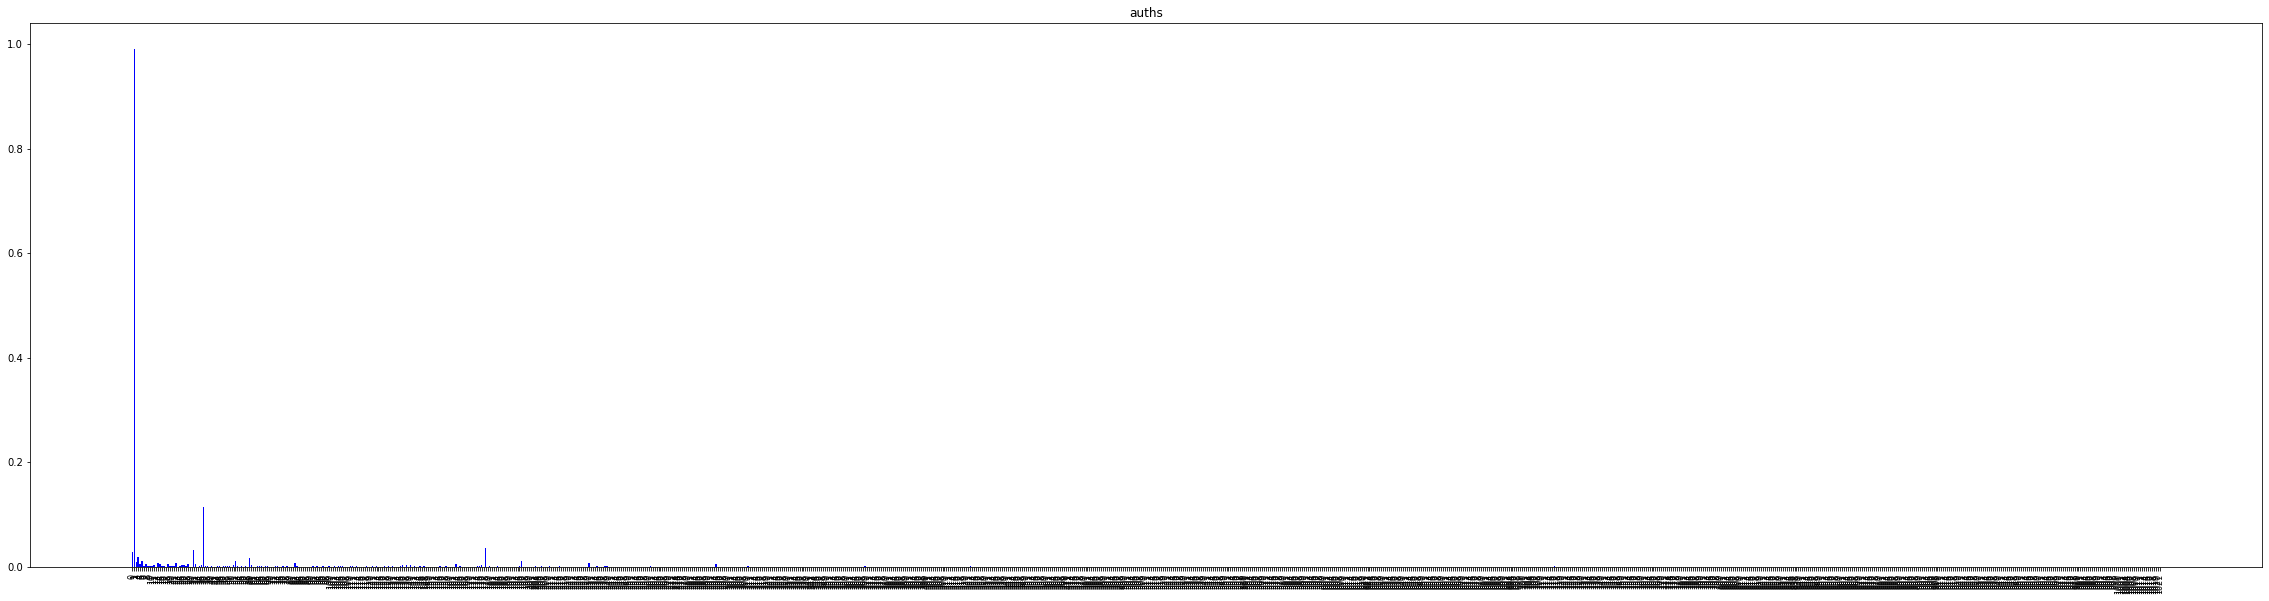

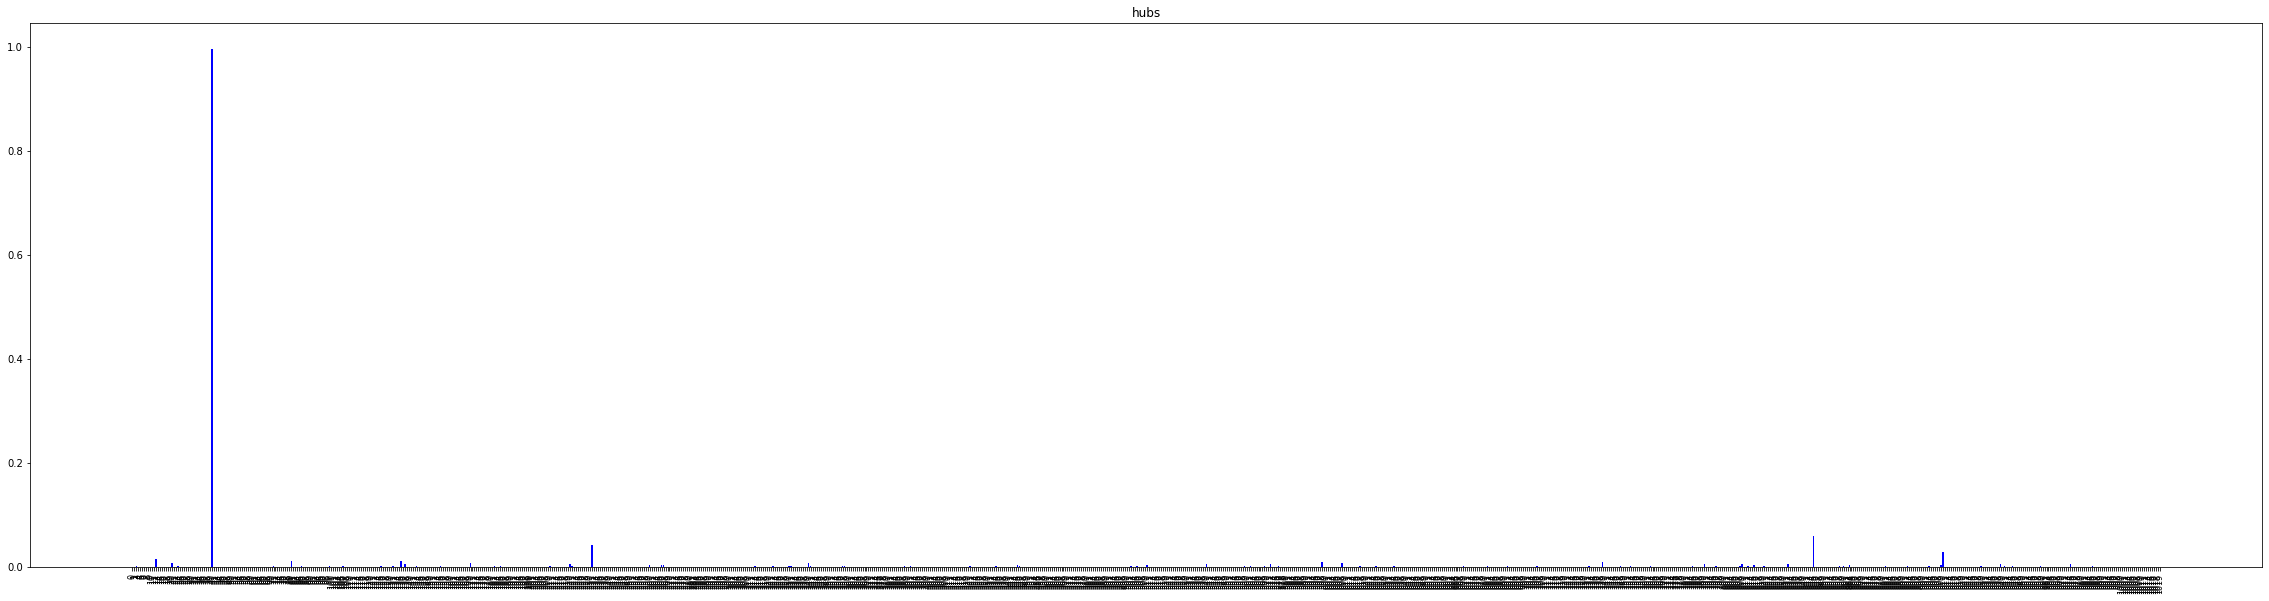

In [23]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize = (40, 10))
labels = list(map(lambda x: str(x), range(len(auths))))
plt.bar(labels, auths, color ='blue', width = 0.7)
plt.xticks(rotation='vertical',fontsize=8)
plt.title('auths')
plt.show()
fig = plt.figure(figsize = (40, 10))
labels = list(map(lambda x: str(x), range(len(hubs))))
plt.bar(labels, hubs, color ='blue', width = 0.7)
plt.xticks(rotation='vertical',fontsize=8)
plt.title('hubs')
plt.show()

In [32]:
k = 10
top_hubs = sorted([(i,x) for i,x in enumerate(hubs)], key = lambda x: -x[1])[:k]
top_auths = sorted([(i,x) for i,x in enumerate(auths)], key = lambda x: -x[1])[:k]
print(top_hubs)
print(top_auths)

[(40, 0.9964850053867111), (845, 0.058093302293745375), (231, 0.04091254454276203), (910, 0.02763743344131759), (12, 0.014886513994762351), (135, 0.011163666151927088), (80, 0.011138287631333501), (598, 0.009323695061557696), (739, 0.009022243057086793), (340, 0.007636657512307252)]
[(1, 0.9911062693983415), (36, 0.1140858058721279), (178, 0.03645516647852918), (31, 0.031537127253750644), (0, 0.02800287457139237), (3, 0.01821051531519488), (59, 0.016221622638043116), (52, 0.010669775250003927), (196, 0.010450749974414255), (5, 0.010196419933779984)]
